
#Credit Card Fraud Detection

Example of outlier detection with autoencoders. Dataset https://www.kaggle.com/mlg-ulb/creditcardfraud from Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles).

It is a highly unbalanced dataset with a very low percetnage of fraudulent credit card transactions. Our purpose is to build a classifier for detecting fraudulent transactions. In this example we will consider them as outliers an will use an autoencoder for detecting them.

##Downloading of dataset


In [ ]:
!wget -O creditfraud.zip https://www.dropbox.com/s/tl20yp9bcl56oxt/creditcardfraud.zip?dl=0

--2023-05-26 04:07:26--  https://www.dropbox.com/s/tl20yp9bcl56oxt/creditcardfraud.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tl20yp9bcl56oxt/creditcardfraud.zip [following]
--2023-05-26 04:07:26--  https://www.dropbox.com/s/raw/tl20yp9bcl56oxt/creditcardfraud.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc96c8ce4d0f5ccddf7d4ddc26d6.dl.dropboxusercontent.com/cd/0/inline/B8x1eyL7QTyev876oJ0fQ2-qGKodnt79WFqRAW-4H5gywGv09XUPLrDFvNV7QrW-0DTt0BF1WU68XTmhBK6cDreyLZIKPojIrnFZnWpyPC9zhWfoD-KhkXWss02YcsmP3u1KH3rAieGAxnirF1Sd5zit0ilXjVlBg24H_dJlfog3fQ/file# [following]
--2023-05-26 04:07:27--  https://uc96c8ce4d0f5ccddf7d4ddc26d6.dl.dropboxusercontent.com/cd/0/inline/B8x1eyL7QTyev876oJ0fQ2-qGKodnt79WFqRAW-4H5gywGv09XUPLr

In [ ]:
!unzip creditfraud.zip

Archive:  creditfraud.zip
  inflating: creditcard.csv          


##Loading libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense

##Loading dataset in Python and taking a first look

In [ ]:
dat = pd.read_csv('creditcard.csv')
dat.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset is highly unbalanced with very few fraudulent credit cards

In [ ]:
dat['Class'].value_counts()/dat['Class'].count()

0    0.998273
1    0.001727
Name: Class, dtype: float64

<Axes: xlabel='Class', ylabel='count'>

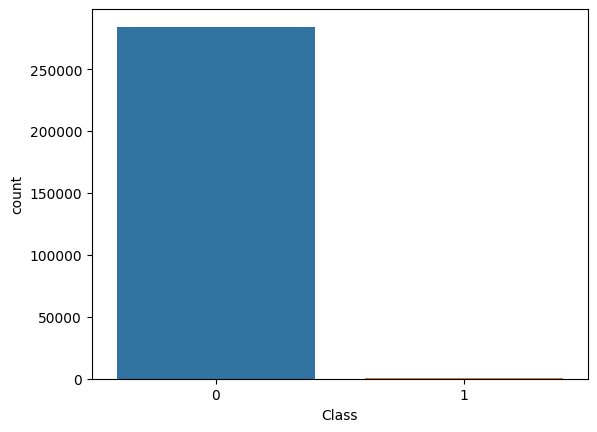

In [ ]:
sns.countplot(x='Class',data=dat)

In [ ]:
dat = dat.drop([ 'Time'], 1)
dat['Amount'] = StandardScaler().fit_transform(dat['Amount'].values.reshape(-1, 1))

<ipython-input-7-4d01bcd2b6d4>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dat = dat.drop([ 'Time'], 1)


Splitting into train and test datasets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dat.drop('Class',1) , dat['Class'], test_size=0.5, random_state=0)

<ipython-input-8-1e3010871204>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(dat.drop('Class',1) , dat['Class'], test_size=0.5, random_state=0)


In [ ]:
y_test.value_counts()/y_test.count()

0    0.998294
1    0.001706
Name: Class, dtype: float64

In [ ]:
y_train.value_counts()/y_train.count()

0    0.998251
1    0.001749
Name: Class, dtype: float64

##First method: using autoencoder's regression error

For our first example we will train our autoencoder only on non fraudulent cases

In [ ]:
X_train_normal = X_train[y_train==0]
X_train_fraud = X_train[y_train==1]

Building an autoencoder with
- an input layer with 29 neurons,
- a hidden layer with 12 neurons,
- an output layer with 29 neurons

In [ ]:
input_layer = Input(shape=(29, ))
encoded = Dense(12, activation='tanh')(input_layer)
decoded = Dense(29, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder.fit(X_train_normal, X_train_normal, epochs = 100, batch_size=128,
validation_data = (X_train_normal, X_train_normal))

Epoch 1/100
1111/1111 [==============================] - 4s 3ms/step - loss: 1.0004 - val_loss: 0.8831
Epoch 2/100
1111/1111 [==============================] - 3s 3ms/step - loss: 0.8571 - val_loss: 0.8391
Epoch 3/100
1111/1111 [==============================] - 3s 3ms/step - loss: 0.8288 - val_loss: 0.8202
Epoch 4/100
1111/1111 [==============================] - 4s 3ms/step - loss: 0.8142 - val_loss: 0.8088
Epoch 5/100
1111/1111 [==============================] - 3s 3ms/step - loss: 0.8049 - val_loss: 0.8012
Epoch 6/100
1111/1111 [==============================] - 3s 3ms/step - loss: 0.7985 - val_loss: 0.7959
Epoch 7/100
1111/1111 [==============================] - 3s 3ms/step - loss: 0.7940 - val_loss: 0.7920
Epoch 8/100
1111/1111 [==============================] - 4s 3ms/step - loss: 0.7907 - val_loss: 0.7895
Epoch 9/100
1111/1111 [==============================] - 3s 3ms/step - loss: 0.7883 - val_loss: 0.7871
Epoch 10/100
1111/1111 [==============================] - 3s 3ms/step - l

In [ ]:
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame(
    {
        'reconstruction_error': mse,
        'true_class': y_train
    }
)
error_df.groupby('true_class').describe()

4451/4451 [==============================] - 6s 1ms/step


reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                      142154.0   0.765601   3.443837  0.041421  0.227804   
1                         249.0  30.166722  43.414993  0.113103  4.259980   

                                              
                  50%        75%         max  
true_class                                    
0            0.390186   0.645143  318.365618  
1           10.675857  27.344418  284.532077

As we can see above the error for non fraudulent case is lower than the error for fraudulent cases. We use a threshold of mean plus 3 sds to classify the test set.

In [ ]:
test_predictions=autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
y_pred=[(lambda er: 1 if er >= 11.078922  else 0)(er) for er in mse]

4451/4451 [==============================] - 8s 2ms/step


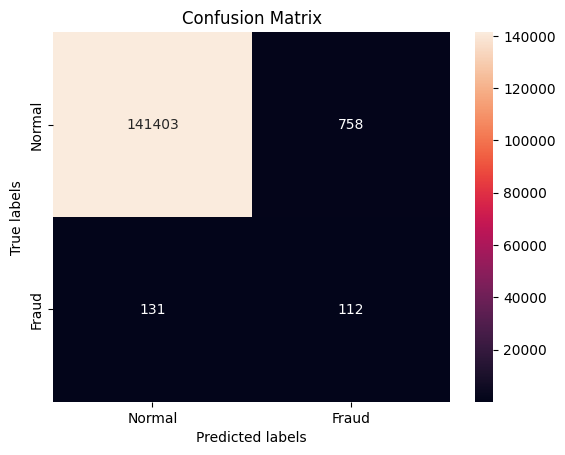

In [ ]:
conf_matrix = metrics.confusion_matrix(y_test,y_pred)

ax=plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax=ax, fmt='g') #annot=True to annotate cells, fmt='g' numbers not scientific form
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Normal', 'Fraud']);
ax.yaxis.set_ticklabels(['Normal', 'Fraud']);
ax.set(yticks=[0, 2], xticks=[0.5, 1.5])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))

##Second method: using encoder part of autoencoder and k-NN

We train using all cases (fraud/non-fraud)in train dataset and use the result to map the instances into a 12-dimensional space. The mapped cases are fed to k-NN for classification.

In [ ]:
input_layer_all = Input(shape=(29, ))
encoded_all = Dense(12, activation='tanh')(input_layer_all)
decoded_all = Dense(29, activation='sigmoid')(encoded_all)
autoencoder_all = Model(input_layer_all, decoded_all)
autoencoder_all.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_all.fit(X_train, X_train, epochs = 100, batch_size=128,
validation_data = (X_train, X_train))

Epoch 1/100
1113/1113 [==============================] - 4s 3ms/step - loss: 1.0434 - val_loss: 0.9385
Epoch 2/100
1113/1113 [==============================] - 5s 4ms/step - loss: 0.9138 - val_loss: 0.8959
Epoch 3/100
1113/1113 [==============================] - 3s 3ms/step - loss: 0.8849 - val_loss: 0.8759
Epoch 4/100
1113/1113 [==============================] - 3s 3ms/step - loss: 0.8697 - val_loss: 0.8643
Epoch 5/100
1113/1113 [==============================] - 3s 3ms/step - loss: 0.8603 - val_loss: 0.8566
Epoch 6/100
1113/1113 [==============================] - 5s 4ms/step - loss: 0.8538 - val_loss: 0.8511
Epoch 7/100
1113/1113 [==============================] - 3s 3ms/step - loss: 0.8489 - val_loss: 0.8468
Epoch 8/100
1113/1113 [==============================] - 4s 4ms/step - loss: 0.8452 - val_loss: 0.8434
Epoch 9/100
1113/1113 [==============================] - 11s 10ms/step - loss: 0.8422 - val_loss: 0.8408
Epoch 10/100
1113/1113 [==============================] - 10s 9ms/step 

In [ ]:
encoder_all = Model(input_layer_all, encoded_all)
enc_all = encoder_all.predict(X_train)

4451/4451 [==============================] - 5s 1ms/step


Loading library for k-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Train the model using the training sets
knn_model.fit(enc_all, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
%%time
knn_predicted = knn_model.predict(encoder_all.predict(X_test))

4451/4451 [==============================] - 6s 1ms/step
CPU times: user 57.6 s, sys: 492 ms, total: 58.1 s
Wall time: 1min


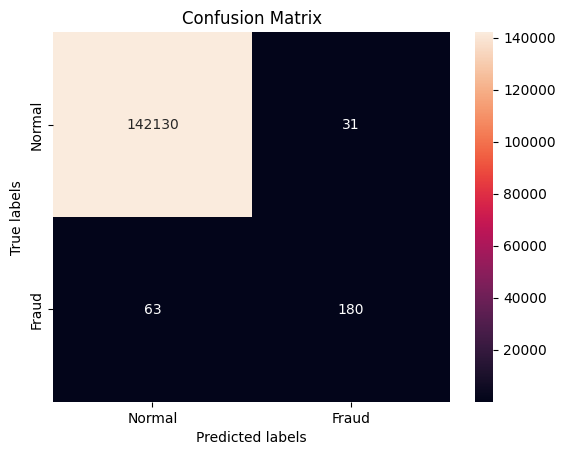

In [ ]:
conf_matrix = metrics.confusion_matrix(y_test,knn_predicted)

ax=plt.subplot()
sns.heatmap(conf_matrix,annot=True, ax=ax, fmt='g') #annot=True to annotate cells, fmt='g' numbers not scientific form
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Normal', 'Fraud']);
ax.yaxis.set_ticklabels(['Normal', 'Fraud']);
ax.set(yticks=[0, 2], xticks=[0.5, 1.5])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))